In [130]:
import sys
sys.path.append('..')
import argparse
import os
import shutil
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import baselines.trainVggBaselineForCIFAR10.vgg as vgg
import wandb
from internal_utils import filter_top_percent_pixels_over_channels, update_dictionary_patch 
from experiments import HybridCosineDistanceCrossEntopyLoss


def get_teacher_model(teacher_checkpoint_path):
    checkpoint = torch.load(teacher_checkpoint_path)
    # assume teacher model is vgg11 for now
    teacher = vgg.vgg11()
    checkpoint = update_dictionary_patch(checkpoint)
    teacher.load_state_dict(checkpoint['new_state_dict'])
    return teacher

args = {
    'arch': 'vgg11',
    'teacher_checkpoint_path': "/home/tromero_client/RL-LRP/baselines/trainVggBaselineForCIFAR10/save_vgg11/checkpoint_299.tar",
    'cpu': False,
    'momentum': 0.9,
    'weight_decay': 5e-4,
    'half': False, 
    'lr': 0.1
}

teacher_model = get_teacher_model(args['teacher_checkpoint_path'])
learner_model = vgg.__dict__[args['arch']]()
learner_model.features = torch.nn.DataParallel(learner_model.features)
if args['cpu']:
    learner_model.cpu()
    teacher_model.cpu
else:
    learner_model.cuda()
    teacher_model.cuda()

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='/home/tromero_client/RL-LRP/baselines/trainVggBaselineForCIFAR10/data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=args['batch_size'], shuffle=True,
    num_workers=args['workers'], pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='/home/tromero_client/RL-LRP/baselines/trainVggBaselineForCIFAR10/data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=args['batch_size'], shuffle=False,
    num_workers=args['workers'], pin_memory=True)

cudnn.benchmark = True

# define loss function (criterion) and pptimizer
criterion = HybridCosineDistanceCrossEntopyLoss(_lambda=0.5)
if args['cpu']:
    criterion = criterion.cpu()
else:
    criterion = criterion.cuda()
    
if args['half']:
    teacher_model.half()
    learner_model.half()
    criterion.half()

optimizer = torch.optim.SGD(learner_model.parameters(), args['lr'],
                            momentum=args['momentum'],
                            weight_decay=args['weight_decay'])
    
    


# for epoch in range(args.start_epoch, args.epochs):
#     adjust_learning_rate(optimizer, epoch)

#     # train for one epoch
#     train(train_loader, model, criterion, optimizer, epoch)

#     # evaluate on validation set
#     prec1 = validate(val_loader, model, criterion)

#     # remember best prec@1 and save checkpoint
#     is_best = prec1 > best_prec1
#     best_prec1 = max(prec1, best_prec1)
#     save_checkpoint({
#         'epoch': epoch + 1,
#         'state_dict': learner_model.state_dict(),
#         'best_prec1': best_prec1,
#     }, is_best, filename=os.path.join(args.save_dir, f'checkpoint_{epoch}.tar'))



Files already downloaded and verified


In [ ]:
import torch
load_checkpoint_path = "/home/tromero_client/RL-LRP/baselines/trainVggBaselineForCIFAR10/save_vgg11/checkpoint_299.tar"

checkpoint = torch.load(load_checkpoint_path)

In [ ]:
checkpoint['state_dict'].keys()


In [ ]:

from collections import OrderedDict
def update_dictionary_patch(checkpoint, model):
    new_state_dict = OrderedDict()
    for key, value in checkpoint['state_dict'].items():
        if 'module' in key:
            new_key = key.replace('module.', '')
        else:
            new_key = key
        new_state_dict[new_key]= checkpoint['state_dict'][key]
    checkpoint['new_state_dict'] = new_state_dict
    return checkpoint


In [ ]:
def validate(val_loader, model):
    """
    Run evaluation
    """
    # switch to evaluate mode
    model.eval()

    for i, (input, target) in enumerate(val_loader):

        # compute output
        with torch.no_grad():
            output = model(input)

        output = output.float()

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        
    return prec1

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
validate(val_loader, model)

In [ ]:
input_image = next(iter(val_loader))

In [ ]:
from experiments import WrapperNet
wrapped_model = WrapperNet(model, hybrid_loss=True)

In [ ]:
class_, images_out = wrapped_model.forward(input_image[0])

In [ ]:
images_out.shape


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([32, 32])


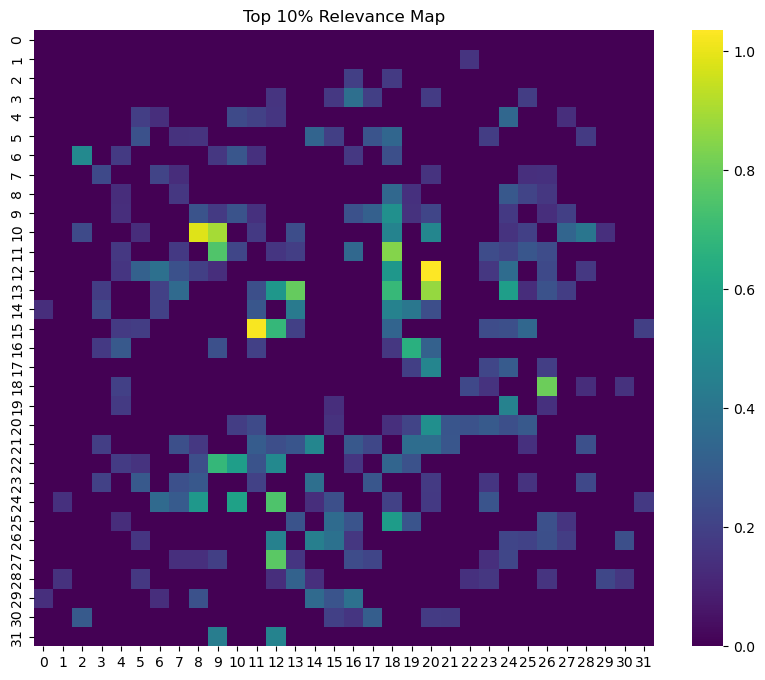

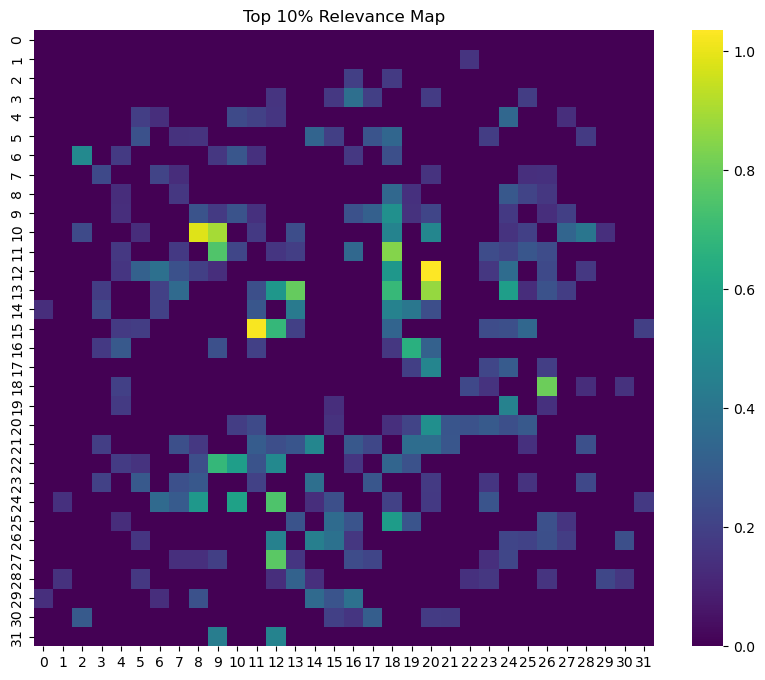

In [123]:

def plot_top_10_percent_heatmap(model_output_image):
    print(model_output_image.shape)
    output_tensor = model_output_image.max(dim=0)[0]
    # Get the top 10% threshold
    print(output_tensor.shape)
    top_10_percent_threshold = torch.quantile(output_tensor, 0.75)

    # Mask out values below the top 10% threshold
    mask = output_tensor >= top_10_percent_threshold

    # Apply the mask to the output tensor
    filtered_output = torch.zeros_like(output_tensor)
    filtered_output[mask] = output_tensor[mask]

    # Convert to numpy for plotting
    output_final = filtered_output.cpu().detach().numpy()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))  # Set the size of the figure (optional)
    sns.heatmap(output_final, cmap='viridis', annot=False)
    plt.title('Top 10% Relevance Map')
    plt.show()

print(images_out[0].shape)
# Assuming your data is in PyTorch tensors and has the shape b, 3, 224, 224
plot_top_10_percent_heatmap(images_out[0])

    
def filter_top_percent_pixels_over_channels(batch_tensor, percentile_cutoff):
    """
    Filters the top x percent of pixels in a batch of images by aggregating over channels.
    Arguments:
        batch_tensor: tensor of shape [b, c, h, w]
        percentile_cutoff: the top x percent threshold (e.g., 0.1 for top 10%)
    Returns:
        filtered_batch: tensor of the same shape as batch_tensor with only the top x percent pixels retained
    """
    b, c, h, w = batch_tensor.shape

    # Compute the maximum value across channels for each pixel
    max_over_channels = batch_tensor.max(dim=1)[0]

    # Flatten the spatial dimensions (h, w) to find the percentile across them
    flattened = max_over_channels.view(b, -1)

    # Calculate the threshold for the top x percent for each image in the batch
    threshold_values = torch.quantile(flattened, percentile_cutoff, dim=-1, keepdim=True)

    # Expand the threshold values to match the max_over_channels tensor shape
    thresholds = threshold_values.view(b, 1, 1).expand(-1, h, w)

    # Create a mask for values greater than or equal to the threshold
    mask = max_over_channels >= thresholds

    # Expand the mask to match the original tensor shape
    mask = mask.unsqueeze(1).expand(-1, c, -1, -1)

    # Apply the mask to retain only the top x percent values
    filtered_batch = torch.zeros_like(batch_tensor)
    filtered_batch[mask] = batch_tensor[mask]

    return filtered_batch
filtered_images = filter_top_percent_pixels_over_channels(images_out, 0.75)
filtered_images.shape
example_heatmap = filtered_images.max(dim=1)[0]
# example_heatmap.shape
plt.figure(figsize=(10, 8))  # Set the size of the figure (optional)
sns.heatmap(example_heatmap[0].detach().numpy(), cmap='viridis', annot=False)
plt.title('Top 10% Relevance Map')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(input_image[0][25].squeeze(0).permute(1, 2, 0))

In [ ]:
input_image = next(iter(val_loader))
transform = transforms.ToPILImage()
image = transform(input_image[0][1])
# Display the image
plt.imshow(image)
plt.title(f'CIFAR-10 Image at Index {43}')
plt.axis('off')  # Optional: Remove axis
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize an image from the DataLoader without transformations
def visualize_raw_image_from_dataloader(dataloader, index):
    # Access the dataset from the DataLoader
    dataset = dataloader.dataset

    # Get the original image and label (if available) without transformations
    if hasattr(dataset, 'data'):
        # For common datasets like CIFAR-10
        image = dataset.data[index]
        if dataset.targets:
            label = dataset.targets[index]
        else:
            label = None
    else:
        # For custom datasets, you may need to access the image directly
        image, label = dataset[index]
        if hasattr(image, 'permute'):
            image = image.permute(1, 2, 0).cpu().detach().numpy()

    # If the image is in range [0, 1], scale to [0, 255]
    if image.max() <= 1.0:
        image = (image * 255).astype('uint8')

    # Display the image
    plt.imshow(image)
    if label is not None:
        plt.title(f'Label: {label}')
    plt.axis('off')  # Optional: Remove axis
    plt.show()

# Example usage:
# dataloader = your DataLoader object
visualize_raw_image_from_dataloader(val_loader, 7)  # Visualize the 6th image in the dataset
